#Heating Functions with Wait-time Scaling

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import sys
sys.path.append('/home/wtb2/Documents/EBTEL_analysis/src')
import ebtel_dem as ebd
import ebtel_configure as ebc
import ebtel_plot as ebp
from imp import reload
reload(ebd)
reload(ebc)
reload(ebp)

/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'ebtel_plot' from '/home/wtb2/Documents/EBTEL_analysis/src/ebtel_plot.py'>

In this notebook, we will test whether we can properly determine heating amplitudes $Q_i$ and wait-times $T_{N,i}$ when they are related by the functional form
$$Q_i\propto T_{N,i}^b$$
with $b=1,2$. Note that our free parameter is $\langle T_N\rangle$ and that our wait times are subject to the constraint
$$N=\frac{T-N\tau_H}{\langle T_N\rangle},$$
where $N\equiv N(\langle T_N\rangle)$ and $\tau_H$ is fixed. Letting $\langle T_N\rangle=(\sum_iT_{N,i})/N$ and the relation $Q_i=\xi T_{N,i}^b$, we can derive an expression for the proportionality constant $\xi$,
$$\xi=\left(\frac{\sum_iQ_i^{1/b}}{T-N\tau_H}\right)^b.$$
Thus, for fixed values of $T,\tau_H$ and our distribution of $Q_i$ values that we have previously constructed (such that $\mathrm{EM}(T)$ is centered on 4 MK), we can find $T_{N,i}$ such that $Q_i\propto T_{N,i}^b$.

First, set some of the static parameters.

In [2]:
total_time = 80000.0
tau_pulse = 100.0
t_wait_mean = np.arange(250,5250,250)
alpha = -1.5
tpeak = 4.0e+6
loop_length  = 40.0
delta_q = 10.0
hn = 1.0e-6*tpeak**(3.5)/(loop_length*1.0e+8)**2

In [3]:
#set everything in the dictionary object
config_dict = {}
config_dict['total_time'] = total_time
config_dict['t_pulse_half'] = tau_pulse/2.0
config_dict['alpha'] = alpha
config_dict['loop_length'] = loop_length
config_dict['heating_shape'] = 'triangle'
config_dict['amp_switch'] = 'file'

Next, declare the configure class to calculate the amplitude array that we need to find the waiting time for each $\langle T_N\rangle$ value.

In [4]:
config = ebc.Configurer(config_dict,'/my/root/dir/',Hn=hn,delta_q=delta_q,build_paths=False,mc=False)

In [5]:
amp_arrays = []
num_events = []
for i in range(len(t_wait_mean)):
    config.config_dictionary['num_events'] = int(np.ceil(config.config_dictionary['total_time']/(2.0*config.config_dictionary['t_pulse_half'] + t_wait_mean[i])))
    config.amp_arrays(t_wait_mean[i])
    amp_arrays.append(config.config_dictionary['amp_array'])
    num_events.append(config.config_dictionary['num_events'])

Now that we have our amplitude arrays of length $N(\langle T_N\rangle)$ for each $T_{N,i}$, we want to calculate the associated wait times.

In [6]:
def wait_time_coefficient(q,T,N,tau,b):
    q_sum = 0
    for i in range(len(q)):
        q_sum = q_sum + q[i]**(1.0/b)
        
    return (q_sum/(T - N*tau))**b

In [7]:
b = 1
t_wait_b1 =[]
for i in range(len(amp_arrays)):
    xi = wait_time_coefficient(amp_arrays[i],config.config_dictionary['total_time'],num_events[i],tau_pulse,b)
    t_wait_b1.append((amp_arrays[i]/xi)**(1.0/b))
    
b = 2.0
t_wait_b2 = []
for i in range(len(amp_arrays)):
    xi = wait_time_coefficient(amp_arrays[i],config.config_dictionary['total_time'],num_events[i],tau_pulse,b)
    t_wait_b2.append((amp_arrays[i]/xi)**(1.0/b))

Now, let's create a sample time vector and create the heating functions to see if these heating amplitudes and start times are sensible.

In [8]:
time = np.arange(0,config_dict['total_time'])

In [9]:
def get_heating_function(t,t_start,t_end,amp,h_bg):
    heat = h_bg
    for i in range(len(t_start)):
        if t_start[i] <= t <= t_end[i]:
            t_mid = t_start[i] + (t_end[i] - t_start[i])/2.0
            if t < t_mid:
                heat = heat + amp[i]/((t_end[i]-t_start[i])/2.0)*(t - t_start[i])
            else:
                heat = heat - amp[i]/((t_end[i]-t_start[i])/2.0)*(t - t_end[i])
                
    return heat

First, we need to find the event starting times.

In [10]:
t_start_b1 = []
t_start_b2 = []
for i in range(len(amp_arrays)):
    ts_temp_b1 = []
    ts_temp_b2 = []
    for j in range(num_events[i]):
        if j==0:
            ts_temp_b1.append(0)
            ts_temp_b2.append(0)
        else:
            ts_temp_b1.append(j*tau_pulse + np.sum(t_wait_b1[i][:j]))
            ts_temp_b2.append(j*tau_pulse + np.sum(t_wait_b2[i][:j]))
    
    t_start_b1.append(np.array(ts_temp_b1))
    t_start_b2.append(np.array(ts_temp_b2))

In [11]:
heating_fns_b1 = []
heating_fns_b2 = []
for i in range(len(amp_arrays)):
    heat_temp_b1 = []
    heat_temp_b2 = []
    for j in range(len(time)):
        heat_temp_b1.append(get_heating_function(time[j],t_start_b1[i],t_start_b1[i]+tau_pulse,amp_arrays[i],3.4e-6))
        heat_temp_b2.append(get_heating_function(time[j],t_start_b2[i],t_start_b2[i]+tau_pulse,amp_arrays[i],3.4e-6))
        
    heating_fns_b1.append(heat_temp_b1)
    heating_fns_b2.append(heat_temp_b2)
    

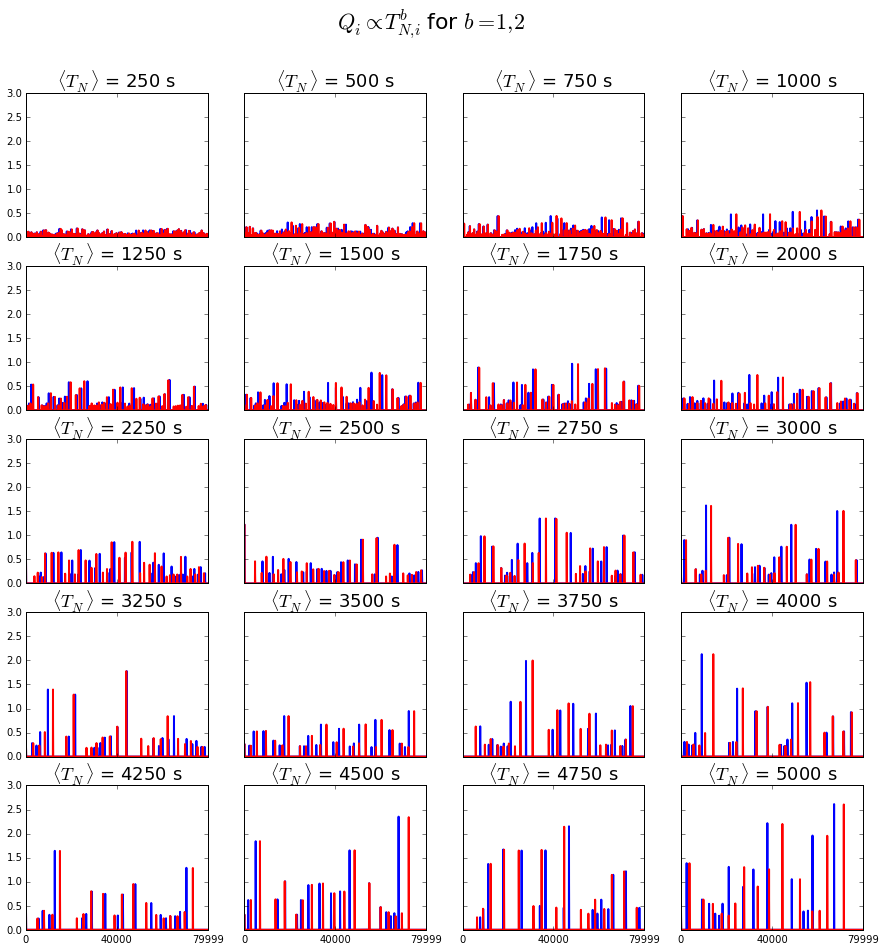

In [12]:
ip = 0
fig,axes = plt.subplots(5,4,figsize=(15,15),sharex=True,sharey=True)
#plt.subplots_adjust(hspace=0,wspace=0)
fig.suptitle(r'$Q_i\propto T_{N,i}^b$ for $b=1,2$',fontsize=22)
#big_ax.set_xlabel(r'$t$ (s)',fontsize=22)
#big_ax.set_ylabel(r'$h$ (ergs cm$^{-3}$ s$^{-1}$)',fontsize=22)
for ax in axes.flatten():
    ax.plot(time,heating_fns_b1[ip],linewidth=2)
    ax.plot(time,heating_fns_b2[ip],'r',linewidth=2)
    ax.set_xlim([time[0],time[-1]])
    ax.set_xticks([time[0],(time[-1]-time[0])/2,time[-1]])
    ax.set_title(r'$\langle T_N\rangle$ = %d s'%(t_wait_mean[ip]),fontsize=18)
    ip = ip + 1

Now, we want to see whether our relationship between $Q$ and $T_N$ is actually being obeyed. We'll plot $Q/T_N^b$ for all values of $\langle T_N\rangle$. If we have done this correctly, then this quantity should be constant ($\xi$) for all $1\le i\le N$.

No file specified. Variable namespace will not be populated.


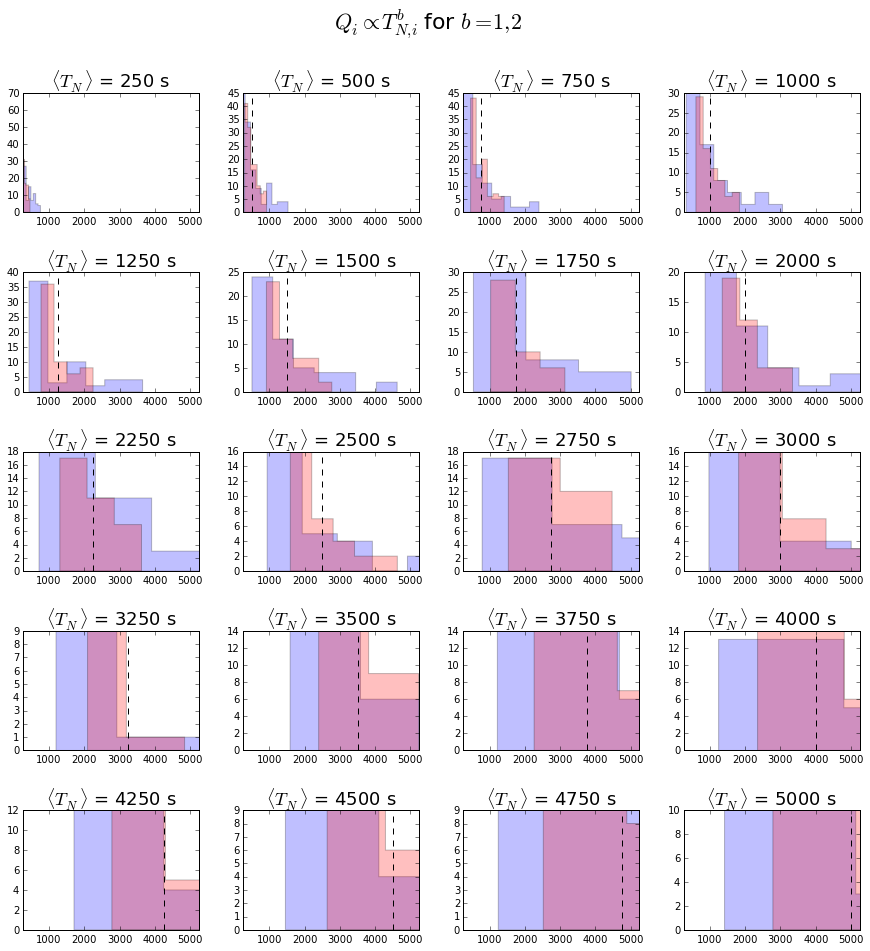

In [13]:
ip = 0
pclass = ebp.Plotter()
fig,axes = plt.subplots(5,4,figsize=(15,15))
plt.subplots_adjust(hspace=0.5,wspace=0.25)
fig.suptitle(r'$Q_i\propto T_{N,i}^b$ for $b=1,2$',fontsize=22)
#big_ax.set_xlabel(r'$t$ (s)',fontsize=22)
#big_ax.set_ylabel(r'$h$ (ergs cm$^{-3}$ s$^{-1}$)',fontsize=22)
for ax in axes.flatten():
    pclass.events = t_wait_b1[ip]
    ax.hist(t_wait_b1[ip],pclass.freedman_diaconis(),histtype='stepfilled',facecolor='blue',alpha=0.25)
    pclass.events = t_wait_b2[ip]
    ax.hist(t_wait_b2[ip],pclass.freedman_diaconis(),histtype='stepfilled',color='red',alpha=0.25)
    ax.axvline(x=t_wait_mean[ip],color='k',linestyle='--')
    ax.set_title(r'$\langle T_N\rangle$ = %d s'%(t_wait_mean[ip]),fontsize=18)
    #ax.set_xticks([])
    #ax.set_yticks([])
    ax.set_xlim([t_wait_mean[0] - (t_wait_mean[-1] - t_wait_mean[-2]),t_wait_mean[-1]] + (t_wait_mean[-1] - t_wait_mean[-2]))
    ip = ip + 1

Now, if we plot $(T_{N,i},Q_i)$ for all wait times $\langle T_N\rangle$ for both $b=1,2$, we should be able to see the power law and linear relations that we have imposed.

In [14]:
from scipy.optimize import curve_fit
def linear_fit(x,a):
    return a*x
def quadratic_fit(x,a):
    return a*x**2

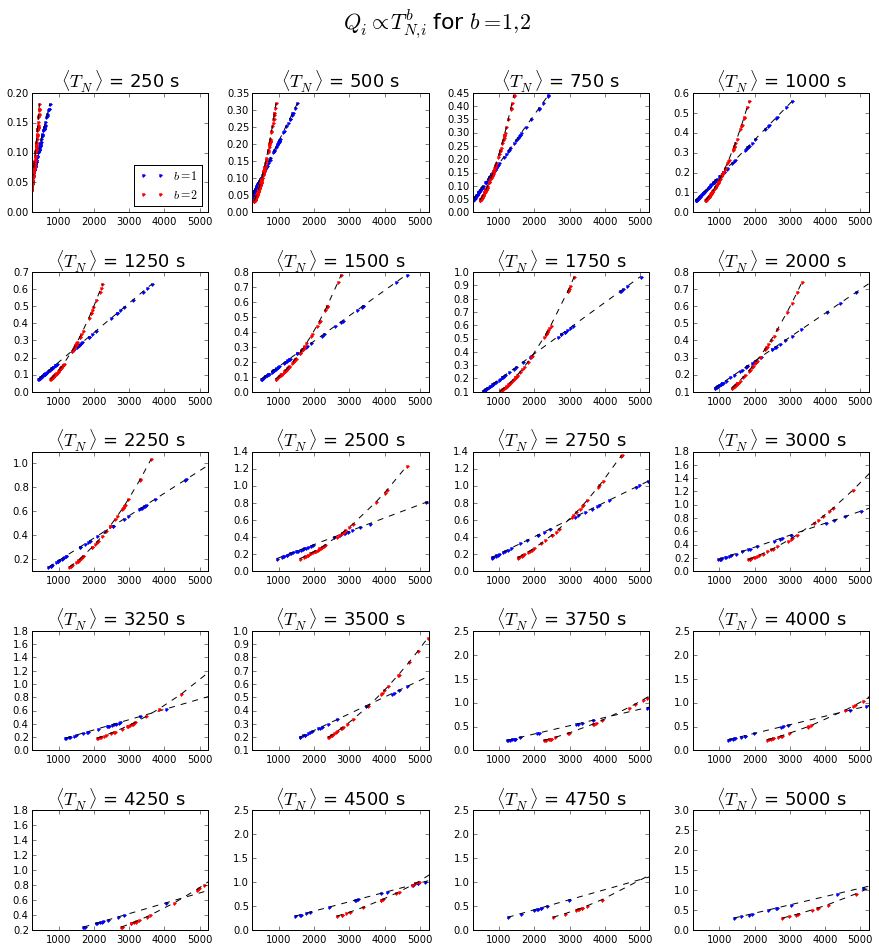

In [15]:
ip = 0
fig,axes = plt.subplots(5,4,figsize=(15,15))
plt.subplots_adjust(hspace=0.5,wspace=0.25)
fig.suptitle(r'$Q_i\propto T_{N,i}^b$ for $b=1,2$',fontsize=22)
for ax in axes.flatten():
    #b=1
    ax.plot(t_wait_b1[ip],amp_arrays[ip],'.b',label=r'$b=1$')
    pars,covar = curve_fit(linear_fit,np.sort(t_wait_b1[ip]),amp_arrays[ip][t_wait_b1[ip].argsort()])
    ax.plot(np.sort(t_wait_b1[ip]),linear_fit(np.sort(t_wait_b1[ip]),*pars),'--k')
    wtc = wait_time_coefficient(amp_arrays[ip],config.config_dictionary['total_time'],num_events[ip],tau_pulse,1.0)
    #print('Tn = %d, b= %d,percent_diff(xi) = %.3e'%(t_wait_mean[ip],1.0,np.fabs(pars - wtc)/(pars + wtc)))
    #b=2
    ax.plot(t_wait_b2[ip],amp_arrays[ip],'.r',label=r'$b=2$')
    pars,covar = curve_fit(quadratic_fit,np.sort(t_wait_b2[ip]),amp_arrays[ip][t_wait_b2[ip].argsort()])
    ax.plot(np.sort(t_wait_b2[ip]),quadratic_fit(np.sort(t_wait_b2[ip]),*pars),'--k')
    wtc = wait_time_coefficient(amp_arrays[ip],config.config_dictionary['total_time'],num_events[ip],tau_pulse,2.0)
    #print('Tn = %d, b= %d,percent_diff(xi) = %.3e'%(t_wait_mean[ip],2.0,np.fabs(pars - wtc)/(pars + wtc)))
    if ip == 0:
        ax.legend(loc=4)
    ax.set_title(r'$\langle T_N\rangle$ = %d s'%(t_wait_mean[ip]),fontsize=18) 
    ax.set_xlim([t_wait_mean[0] - (t_wait_mean[-1] - t_wait_mean[-2]),t_wait_mean[-1]] + (t_wait_mean[-1] - t_wait_mean[-2]))
    ip = ip + 1
    

Thus, one can see that for all $\langle T_N\rangle$, we can construct wait times which obey the desired relationship $Q\propto T_N^b$ for $b=1,2$.